Fkrst, some definitions. I am following [this chapter](https://nbviewer.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/08-Designing-Kalman-Filters.ipynb) of Kalman and Bayesian Filters in Python to give me some structure.

## Choose State Variables
I first need to define my x. 

$\textbf{x}$ consists of the PM2.5 values, wind x and wind y components in a given square. So, this would be 80x50x3 or 12000 values. woof.

I think I'll say the matrix is structured as follows:

$$\textbf{x} = \begin{pmatrix} P_{0 0} & P_{0 1} & \cdots & P_{i j} & x_{0 0} & x_{0 1} & \cdots & x_{i j} & y_{0 0} & y_{0 1} & \cdots & y_{ij} \end{pmatrix}^T$$

For the following math, I will be calculating 2D matrices of P, x, and y with 80 rows and 50 columns (as defined by the CMAQ data) and then smushing them together later, because that'll work a lot better for my brain.

In [1]:
import numpy as np
import pandas as pd

In [2]:
windX = np.load('meteostat/windX_array.npy')
windY = np.load('meteostat/windY_array.npy')
windXdates = pd.read_csv('meteostat/windXdates.csv')
windYdates = pd.read_csv('meteostat/windYdates.csv')
display(windX.shape)
display(windXdates.shape)

(4383, 50, 80)

(4383, 1)

In [3]:
# put index in its own column, to eventually subset the windX and windY dateframes
windXdates = windXdates.reset_index()
windXdates

,index,time
0,0,2010-01-01
1,1,2010-01-02
2,2,2010-01-03
3,3,2010-01-04
4,4,2010-01-05
...,...,...
4378,4378,2021-12-27
4379,4379,2021-12-28
4380,4380,2021-12-29
4381,4381,2021-12-30


In [4]:
year = 2010
PM25 = np.load(f'PM2.5/{year}PM_array.npy')
PM25dates = pd.read_csv(f'PM2.5/{year}PMdates.csv')
display(PM25.shape)
display(PM25dates.shape)
# flattens down the columns first, then the rows
PM25flat = PM25[0,:,:].flatten('F')
display(PM25flat.shape)

PM25Z = PM25[0,:,:]

(365, 50, 80)

(365, 1)

(4000,)

In [5]:
# subset windX and windY by the dates that are in PM25
PM25datesmerge = PM25dates.merge(windXdates, how='left', left_on='Date Local', right_on='time')
display(PM25datesmerge.loc[0:2, 'index'])
windXYear = windX[PM25datesmerge['index'],:,:]
windYYear = windY[PM25datesmerge['index'],:,:]
windXYear.shape

windXYearflat = windXYear[0,:,:].flatten('F')
windYYearflat = windYYear[0,:,:].flatten('F')
display(windXYearflat.shape)

windXZ = windXYear[0,:,:]

0    0
1    1
2    2
Name: index, dtype: int64

(4000,)

In [6]:
# here's an example x vector, stacking them together
X = np.hstack((PM25flat, windXYearflat, windYYearflat))
X.shape

(12000,)

In [7]:
np.isnan(X).sum()

10598

## Design State Transition Function

Ok, first difficult problem, how to define $\textbf F$, where:
$${\textbf x}_k = \textbf F  {\textbf x}_{k-1}$$

I don't need an exact equation, but something as close as possible so that the optimization algorithm can have a decent starting point.

### For the PM2.5 values:

I want to use the 5x5 grid surrounding a square as the estimators.

For a given square like (3,3), the equation will be $$\sum_{i=1}^5 \sum_{j=1}^5 \sqrt{ab} * P_{ij}$$ 
where $a = 1 - \frac{|\text{ideal\_angle} - \text{actual\_angle}|}{\pi}$, $\text{ideal\_angle} = \tan^{-1} (\frac{-(3-j)}{(3-i)})$, $\text{actual\_angle} = \tan^{-1} (\frac{w_y}{w_x})$, $b=\frac1{(3-i)^2 + (3-j)^2}$.

In summary, I'm doing a weighted average of PM values from the surrounding 5x5 squares, where the weights are a geometric mean between a measure from 0 to 1 of whether the wind vector is pointing at the target square (1) or not (0), and an inverse squared distance, where 1 is the closest distance (directly adjacent) and it goes down to 0 from there. The purpose of the geometric mean is so that low values of wind are heavily penalized in the overall weight.

All together (where the next value of $P_{ij}$ is determined from the previous time step's $P_{ij}$ values):

$${P_{ij}}_{new} = \sum_{k=i-2}^{i+2} \sum_{l=j-2}^{j+2} \sqrt{\left(1 - \frac{|\tan^{-1} (\frac{-(3-l)}{(3-k)}) - \tan^{-1} (\frac{w_y}{w_x})|}{\pi}\right)\left(\frac1{(3-k)^2 + (3-l)^2}\right)} * P_{kl}$$ 

Woof. Oh and obviously the weights are going to be normalized by the sum of all of the weights for that square.

Also, for the squares that actually have sensors within them, I want to have those mostly trust the sensor values, with maybe a bit of wind influence (like 10\% maybe?).

So for when i and j equal the value, I'll throw out the above calculated weight and instead do 9 times the sum of the other weights.

MUST DOUBLE CHECK THE OUTPUT OF THE SUBTRACTION

Then, I'll construct $\textbf F$ for the PM2.5 values with the above calculations (combined with the below wind calculations).

Soooo... I realized that the function above cannot be expressed in terms of a linear function, so I'm going to transition into unscented kalman filter instead, which should be fine I think.

So then, ${\textbf x}_k = \textbf F(  {\textbf x}_{k-1})$

In [8]:
7 % (2 * np.pi)

0.7168146928204138

In [9]:
import math
def mat_to_flat(row, col, shape:list):
    ### converts matrix coordinates to the flat coordinates
    return (col * shape[0]) + row

# fix angle wraparound difference issue
# gives absolute smallest difference between two angles, outputs values from 0 to pi
def abs_diff_wraparound(a,b):
    return abs(math.atan2(math.sin(a - b), math.cos(a - b)))

In [10]:
def PMcalc(x):
    row = PM25.shape[1]
    col = PM25.shape[2]

    size = row * col

    # Extract PM, wind x, and wind y from the x vector
    PM = x[:size].reshape(row, col, order='F')
    w_x = x[size:2*size].reshape(row, col, order='F')
    w_y = x[2*size:].reshape(row, col, order='F')

    PM_new = np.zeros_like(PM)

    # i and j denote the current square whose weights are being calculated
    for i in range(row):
        for j in range(col):
            
            # y and x denote the "target" square that will be a part of the weighted average
            low_y = i - 2 if i - 2 >= 0 else 0
            high_y = i + 2 if i + 2 < PM25.shape[1] else PM25.shape[1] - 1
            low_x = j - 2 if j - 2 >= 0 else 0
            high_x = j + 2 if j + 2 < PM25.shape[2] else PM25.shape[2] - 1

            # create 5x5 grid of squares surrounding i,j square, except on the edges where it cuts off
            weights = np.zeros((high_y-low_y+1,high_x-low_x+1)).flatten()
            w = 0
            # math uses (x,y) which is (col, row), numpy uses (y,x) which is (row, col)
            for y in range(low_y, high_y+1):
                for x in range(low_x, high_x+1):
                    if (y == i and x == j) and not np.isnan(PM[y,x]):
                        weights[w] = 10
                        w += 1
                        continue

                    if np.isnan(PM[y,x]) or \
                        (y == i and x == j) or \
                        (np.isnan(w_y[y,x]) or np.isnan(w_x[y,x])) or \
                        (w_y[y,x] == 0 and w_x[y,x] == 0):
                        weights[w] = 0
                        w += 1
                        continue
                    
                    # print(f'({x}, {y})')
                    # find difference between ideal angle between target and current
                    ideal_ang = math.atan2(-(j-y),(i-x))
                    # print(f'ideal: x: {(i-x)}, y: {-(j-y)}, ang: {ideal_ang}')
                    actual_ang = math.atan2(w_y[y,x],w_x[y,x])
                    # print(f'actual: x: {w_x[y,x]}, y: {w_y[y,x]}, ang: {actual_ang}')
                    a = 1 - (abs_diff_wraparound(ideal_ang,actual_ang) / np.pi)

                    # find inverse square distance between target and current
                    b = 1 / ((i-y)**2 + (j-x)**2)
                    
                    # print(f'a: {a:.2f}, b: {b:.2f}')
                    # geometric mean of a and b
                    weights[w] = (a*b)**0.5
                    w += 1

            # normalize all to 1
            sumWeight = np.nansum(weights)
            if sumWeight == 0:
                weights = np.zeros((high_y-low_y+1,high_x-low_x+1))
            else:
                weights = weights.reshape((high_y-low_y+1,high_x-low_x+1)) / sumWeight
            PM_new[i,j] = np.nansum(np.multiply(weights, PM[low_y:high_y+1, low_x:high_x+1]))

    return PM_new

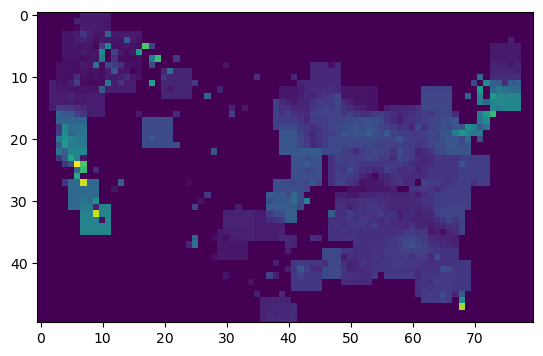

In [11]:
import matplotlib.pyplot as plt
test = PMcalc(X)
plt.imshow(test)

In [12]:
test.flatten('F')

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
# PM = np.array([[10, 0, 0, 0, 3],
#                [0, 0, 0, 0, 0],
#                [0, 2, 10, 0, 0],
#                [0, 0, 0, 0, 0],
#                [1000, 0, 0, 0, 0]])

# w_x = np.array([[1, 0, 0, 0, -1],
#                [0, 0, 0, 0, 0],
#                [0, 1, 0, 0, 0],
#                [0, 0, 0, 0, 0],
#                [0, 0, 0, 0, 0]])

# w_y = np.array([[-1, 0, 0, 0, -3],
#                [0, 0, 0, 0, 0],
#                [0, 0, 0, 0, 0],
#                [0, 0, 0, 0, 0],
#                [1, 0, 0, 0, 0]])

# i = 2
# j = 2

# # y and x denote the "target" square that will be a part of the weighted average
# low_y = i - 2 if i - 2 >= 0 else 0
# high_y = i + 2 if i + 2 < PM25.shape[1] else PM25.shape[1] - 1
# low_x = j - 2 if j - 2 >= 0 else 0
# high_x = j + 2 if j + 2 < PM25.shape[2] else PM25.shape[2] - 1

# # create 5x5 grid of squares surrounding i,j square, except on the edges where it cuts off
# weights = np.zeros((high_y-low_y+1,high_x-low_x+1)).flatten()
# w = 0
# # math uses (x,y) which is (col, row), numpy uses (y,x) which is (row, col)
# for y in range(low_y, high_y+1):
#     for x in range(low_x, high_x+1):
#         if (y == i and x == j) and not np.isnan(PM[y,x]):
#             weights[w] = 10
#             w += 1
#             continue

#         if np.isnan(PM[y,x]) or \
#             (y == i and x == j) or \
#             (np.isnan(w_y[y,x]) or np.isnan(w_x[y,x])) or \
#             (w_y[y,x] == 0 and w_x[y,x] == 0):
#             weights[w] = 0
#             w += 1
#             continue
        
#         print(f'({x}, {y})')
#         # find difference between ideal angle between target and current
#         ideal_ang = math.atan2(-(j-y),(i-x))
#         print(f'ideal: x: {(i-x)}, y: {-(j-y)}, ang: {ideal_ang}')
#         actual_ang = math.atan2(w_y[y,x],w_x[y,x])
#         print(f'actual: x: {w_x[y,x]}, y: {w_y[y,x]}, ang: {actual_ang}')
#         a = 1 - (abs_diff_wraparound(ideal_ang,actual_ang) / np.pi)

#         # find inverse square distance between target and current
#         b = 1 / ((i-y)**2 + (j-x)**2)
        
#         print(f'a: {a:.2f}, b: {b:.2f}')
#         # geometric mean of a and b
#         weights[w] = (a*b)**0.5
#         w += 1

# # normalize all to 1
# sumWeight = np.nansum(weights)
# if sumWeight == 0:
#     weights = np.zeros((high_y-low_y+1,high_x-low_x+1))
# else:
#     weights = weights.reshape((high_y-low_y+1,high_x-low_x+1)) / sumWeight
# weights


### For the wind values:

I think a similar sort of inverse distance weighting would work, so something like (for the (3,3) square):

$$\sum_{i=1}^5 \sum_{j=1}^5 \frac1{(3-i)^2 + (3-j)^2} * \bar{w}$$

Where $\bar{w} = \begin{pmatrix} w_x & w_y \end{pmatrix}^T$ (the x and y components of the wind)

Similar to before where the weights are normalized by the sum of all of the weights, and when there's actually a wind sensor in the square it'll increase the weight on it by a lot.

In [14]:
def windCalc(x):
    row = PM25.shape[1]
    col = PM25.shape[2]

    size = row * col

    # Extract PM, wind x, and wind y from the x vector
    PM = x[:size].reshape(row, col, order='F')
    w_x = x[size:2*size].reshape(row, col, order='F')
    w_y = x[2*size:].reshape(row, col, order='F')

    w_x_new = np.zeros_like(w_x)
    w_y_new = np.zeros_like(w_y)

    # i and j denote the current square whose weights are being calculated
    for i in range(row):
        for j in range(col):
            
            # y and x denote the "target" square that will be a part of the weighted average
            low_y = i - 2 if i - 2 >= 0 else 0
            high_y = i + 2 if i + 2 < PM25.shape[1] else PM25.shape[1] - 1
            low_x = j - 2 if j - 2 >= 0 else 0
            high_x = j + 2 if j + 2 < PM25.shape[2] else PM25.shape[2] - 1

            # create 5x5 grid of squares surrounding i,j square, except on the edges where it cuts off
            weights = np.zeros((high_y-low_y+1,high_x-low_x+1)).flatten()
            w = 0
            # math uses (x,y) which is (col, row), numpy uses (y,x) which is (row, col)
            for y in range(low_y, high_y+1):
                for x in range(low_x, high_x+1):
                    if (y == i and x == j) and not np.isnan(PM[y,x]):
                        weights[w] = 10
                        w += 1
                        continue

                    if np.isnan(PM[y,x]) or \
                        (y == i and x == j) or \
                        (np.isnan(w_y[y,x]) or np.isnan(w_x[y,x])) or \
                        (w_y[y,x] == 0 and w_x[y,x] == 0):
                        weights[w] = 0
                        w += 1
                        continue
                    
                    # print(f'({x}, {y})')
                    
                    # find inverse square distance between target and current
                    b = 1 / ((i-y)**2 + (j-x)**2)
                    
                    # print(f'b: {b:.2f}')
                    weights[w] = b
                    w += 1

            # normalize all to 1
            sumWeight = np.nansum(weights)
            if sumWeight == 0:
                weights = np.zeros((high_y-low_y+1,high_x-low_x+1))
            else:
                weights = weights.reshape((high_y-low_y+1,high_x-low_x+1)) / sumWeight
            w_x_new[i,j] = np.nansum(np.multiply(weights, w_x[low_y:high_y+1, low_x:high_x+1]))
            w_y_new[i,j] = np.nansum(np.multiply(weights, w_y[low_y:high_y+1, low_x:high_x+1]))
    return (w_x_new, w_y_new)

In [15]:
windCalc(X)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [16]:
def fx(x, df=1):
    PM_new = PMcalc(x)
    w_x_new, w_y_new = windCalc(x)

    return np.hstack((PM_new.flatten('F'), w_x_new.flatten('F'), w_y_new.flatten('F')))

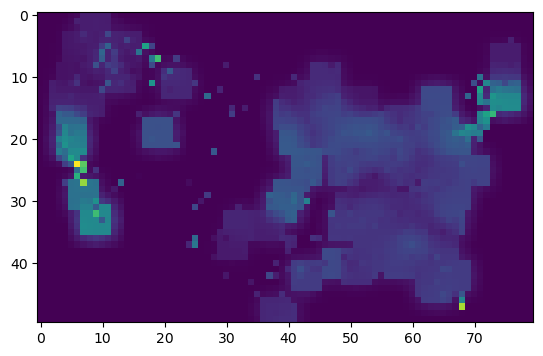

In [17]:
# ok forwards prediction works :o
plt.imshow(fx(fx(X))[0:4000].reshape(50,80,order='F'))

## Design the Process Noise Matrix
Now I have to make $\textbf Q$, which is the covariance matrix of uncertainty for the values in x, i.e. they describe the $\sigma$ of each $\mu$ for every value of $\textbf{x}$, as well as covariances between all variables. This is kind of a pain. I'll have to estimate covariance of both the PM values and the wind components. Thankfully the algorithm will correct my guesses over time, but I need a decent measure.

Ok, I obviously want the squares with actual sensors in them to have the lowest variances (not zero because then the algorithm trusts them infinitely), maybe like $0.5^2$ based on the range of the PM values

Then, the squares with estimates should be graded on how many of the 5x5 squares are from actual PM values, and the $\sigma$ estimate scales higher with less actual sensors, up to a point where if all 5x5 squares are estimated, then the covariance is extremely high, like $8^2$? 

Ok, so let's say $e(x,y) = I(\text{does index xy has a valid PM sensor in it?})$, so a 1 if it does have data, and a 0 if not. For the diagonals of the covariance matrix (which are just variance measurements):

$$ \sigma_{i,j}^2 = 
\begin{cases} 
0.5^2 & e(i,j) = 1 \\ 
(\frac{7.5}{24} * (24 - \sum_{k=i-2, k \neq i}^{i+2} \sum_{l=j-2, l \neq j}^{j+2} e(k,l)) + 0.5)^2& e(i,j) = 0 
\end{cases}$$

The $\frac{7.5}{24}$ and $0.5$ changes the range of the inner function from $[0,24]$ to $[0.5, 8]$, which seems reasonable to me for a $\sigma$ value for this dataset.

Then, for the off-diagonals, I need to assume some covariance. I don't really know what they'll be, but I can make some guesses and the algorithm will correct those guesses over time.

Since $cov(x,y) \leq \sqrt{var(x)* var(y)}$ by Cauchy-Scwhartz, the covariance between two squares must follow that inequality. How about I say that the covariance is maximum ( when they are next to each other, and tapers off linearly until 0? What would be a valid distance where the pollution would be unrelated?

Ok, I'll base it on normal wind speed, which is less than 20 mph, or 32 km/hr. This means that pollution could potentially travel 768 kilometers in 24 hours... which is a lot. The squares are 36km, so that would span 21 squares. Eek. I'm gonna just say 10 squares and call it there.

So, $\text{cov}(P_{ij}, P_{kl}) = w_{ijkl} * \sqrt{var(P_{ij})* var(P_{kl})}$, where 
$$w_{ijkl} = \begin{cases} 
\frac{9 - (|i-k| + |k-l|)}{9} & |i-k| + |k-l| <= 9 \\ 
0 & |i-k| + |k-l| \geq 10 = 0 
\end{cases}$$

So, $w_{ijkl}$ is 1 when directly adjacent squares, then decreases by $\frac19$ for each square away. This isn't perfect because of diagonals, yada yada.

I think I'll do similar for the wind as well, probably with different estimated variances.

In [18]:
def E(i, j):
    return ~np.isnan(PM25Z[i, j])

def PMQ(x):
    row = PM25.shape[1]
    col = PM25.shape[2]

    size = row * col

    # Extract PM, wind x, and wind y from the x vector
    PM = x[:size].reshape(row, col, order='F')
    w_x = x[size:2*size].reshape(row, col, order='F')
    w_y = x[2*size:].reshape(row, col, order='F')

    Q_covariance = np.zeros((size, size))
    for h in range(size):
        x, y = divmod(h, row)
        if E(y,x):
            Q_covariance[h,h] = 0.5**2
        else:
            # y and x denote the "target" square that will be a part of the weighted average
            low_y = y - 2 if y - 2 >= 0 else 0
            high_y = y + 2 if y + 2 < PM25.shape[1] else PM25.shape[1] - 1
            low_x = x - 2 if x - 2 >= 0 else 0
            high_x = x + 2 if x + 2 < PM25.shape[2] else PM25.shape[2] - 1

            sum = 0
            for y in range(low_y, high_y+1):
                for x in range(low_x, high_x+1):
                    sum += E(y,x)
            Q_covariance[h,h] = (7.5/24 * (24 - sum) + 0.5)**2
    return Q_covariance


In [19]:
pmq = PMQ(X)
sum(pmq.diagonal() != 0.25)

3628

In [20]:
# check that the places that are not considered missing are the same in Q and in the PM25Z (measurements array)
idx1 = np.where(pmq.diagonal() == 0.25)[0]
idx2 = np.where(~np.isnan(PM25Z).flatten('F'))[0]
np.array_equal(idx1, idx2)

True

In [21]:
def Ewind(i, j):
    return ~np.isnan(windXZ[i, j])

def WindQ(x):
    row = PM25.shape[1]
    col = PM25.shape[2]

    size = row * col

    # Extract PM, wind x, and wind y from the x vector
    PM = x[:size].reshape(row, col, order='F')
    w_x = x[size:2*size].reshape(row, col, order='F')
    w_y = x[2*size:].reshape(row, col, order='F')

    Q_xcovariance = np.zeros((size, size))
    for h in range(size):
        x, y = divmod(h, row)
        if Ewind(y,x):
            Q_xcovariance[h,h] = 3**2
        else:
            # y and x denote the "target" square that will be a part of the weighted average
            low_y = y - 2 if y - 2 >= 0 else 0
            high_y = y + 2 if y + 2 < PM25.shape[1] else PM25.shape[1] - 1
            low_x = x - 2 if x - 2 >= 0 else 0
            high_x = x + 2 if x + 2 < PM25.shape[2] else PM25.shape[2] - 1

            sum = 0
            for y in range(low_y, high_y+1):
                for x in range(low_x, high_x+1):
                    sum += Ewind(y,x)
            # 17/24*(24 - sum) + 3 has range from [3,20] (i think), which seems fine to me for standard deviation of mph wind
            Q_xcovariance[h,h] = (17/24*(24 - sum) + 3)**2
    return Q_xcovariance


In [22]:
windq = WindQ(X)

In [23]:
from scipy.linalg import block_diag
Q = block_diag(pmq, windq, windq)

In [24]:
# I said I was going to add covariances but i'm skipping it for now
# TODO: add covariances as described

# Design the Measurement Function
Now I need to design $\textbf H$, the measurement function that converts $\textbf x$ into the shape of $\textbf z$, the measurements. I think this design is critical, because the measurement vector $\textbf z$ will likely be changing shape as stations gain data and lose data. The structure is $\textbf z = \textbf H \textbf x$, so H will have (# of measurements) rows and (80x50x3) columns.

I think it's pretty simple, just select the correct x value for each sensor value.

Given square (0,0) and (0,2) have sensors, and (0,1) does not, the conversion from $\textbf x$ to measurement would just have to skip (0,1), since it wouldn't have a sensor value.
So:
$$\begin{align*}
zP_{00} &= 1 * P_{00} + 0 * x_{00} + 0 * y_{00} + 0 * P_{01} + \cdots \\
zx_{00} &= 0 * P_{00} + 1 * x_{00} + 0 * y_{00} + 0 * P_{01} + \cdots \\
zy_{00} &= 0 * P_{00} + 0 * x_{00} + 1 * y_{00} + 0 * P_{01} + \cdots \\
zP_{02} &= 0 * P_{00} + 0 * x_{00} + 0 * y_{00} + \cdots + 1 * P_{02}
\end{align*}$$

$$\textbf H = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &\cdots \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &\cdots \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 &\cdots \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 &\cdots \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 &\cdots \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 &\cdots \\
\cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots &\cdots
\end{bmatrix}$$

Then, $\textbf H$ should be able to be changed as the number of measurements changes. I hope. I *think* this will work with the equations.

In [25]:
def hx(x):
    # make PM measurement matrix
    indices = np.where(~np.isnan(PM25Z.flatten('F')))[0]
    n = len(PM25Z.flatten('F'))  # total number of columns (length of each row)

    PMH = np.eye(n)[indices]

    # make wind measurement matrix (windX and windY should be the same)
    indices = np.where(~np.isnan(windXZ.flatten('F')))[0]
    n = len(windXZ.flatten('F'))  # total number of columns (length of each row)

    WindH = np.eye(n)[indices]

    # stack into H
    H = block_diag(PMH, WindH, WindH)

    return H @ x

# Design the Measurement Noise Matrix
I now make the covariance matrix $\textbf R$ that describes the variance and covariances of the measurements in $\textbf z$. I will assume that the sensors have independent noise. I have no idea what the actual variance of these sensors are, so maybe I'll just steal from above.

Let's say PM sensors have a variance of $0.5^2$ and wind sensors have variance of $3^2$. This is totally arbitrary and I'll probably tune this later. So, R will be a diag matrix with $0.5^2$, $3^2$, and $3^2$ repeating for each sensor value in $\textbf z$.

$$\textbf R = \begin{bmatrix}
\sigma_{P_{00}} & 0 & 0 & \cdots\\
0 & \sigma_{x_{00}} & 0 & \cdots\\
0 & 0 & \sigma_{y_{00}} & \cdots\\
\cdots & \cdots & \cdots & \cdots
\end{bmatrix}$$

In [26]:
numPM = np.sum(~np.isnan(PM25Z.flatten('F')))
numWind = np.sum(~np.isnan(windXZ.flatten('F')))

In [27]:
R = np.diag(np.hstack((np.repeat(0.5**2, numPM), np.repeat(3**2, numWind*2))))
R.shape

(1402, 1402)

# Set Initial Conditions
I must set the initial $\textbf x$ and $\textbf P$.

I think I'll just use kriging to interpolate the initial sensor data geospatially. Then, I'll do similar covariance calculations as $\textbf Q$, stated above, based on whether surrounding squares have sensor values or not.

---
Ok, so that's all of the math defined. Now, I need to code it. Wahoo.

In [32]:
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import JulierSigmaPoints

from tqdm import tqdm

sigmas = JulierSigmaPoints(n=12000, kappa=1)

In [33]:
ukf = UnscentedKalmanFilter(dim_x=12000, dim_z=numPM+numWind, dt=1., hx=hx, fx=fx, points=sigmas)
ukf.P = Q #Q initially
ukf.R = R
ukf.Q = Q

zs, xs = [], []
for i in tqdm(range(1,PM25.shape[0])):
    PM25Z = PM25[i,:,:]
    windXZ = windX[i,:,:]
    windYZ = windX[i,:,:]
    Z = np.hstack((PM25Z.flatten('F'), windXZ.flatten('F'), windYZ.flatten('F')))

    ukf.predict()
    ukf.update(Z)

    xs.append(ukf.x[0:4000])
    zs.append(Z)


  0%|                                                                                           | 0/364 [34:19<?, ?it/s]

KeyboardInterrupt

